In [ ]:
#Run the following code to print multiple outputs from a cell
get_ipython().ast_node_interactivity = 'all'

# Inferential Modeling

## Importing & Profiling the Data
For this worksheet, we'll be using a file called, "Cars.csv", that contains the following fields:

* mpg: Miles/(US) gallon
* disp: Displacement (cu. in.)
* weight: Weight (lbs.)
* trans: Transmission (“auto”, “manual”)
* likes: # of reviews that “like” this car model

Let's import the file, "Cars.csv", and save it in a variable called `df`. Then, do some initial data profiling of the data. 

In [ ]:
import pandas as pd
df = pd.read_csv("Cars.csv")
df
df.dtypes

Let's see if there are missing values and get summary stats for the quantitative variables:

In [ ]:
df.isna().sum()
df.describe()

Let's see the breakdown of "auto" vs. "manual" for the `trans` variable:

In [ ]:
df["trans"].value_counts()
df["trans"].value_counts(normalize = True)
df["trans"].value_counts(normalize = True).plot.bar()

And now look at histograms for the quantitative variables to understand their distributions:

In [ ]:
df["mpg"].plot.hist(bins = 30)

In [ ]:
df["weight"].plot.hist(bins = 30)

In [ ]:
df["disp"].plot.hist(bins = 30)

In [ ]:
df["likes"].plot.hist(bins = 30)

## Looking for relationships

When building linear models, it's a good idea to first look at scatterplots to see if the relationship is linear. A quick way to do this is with the `scatter_matrix` function:

In [ ]:
pd.plotting.scatter_matrix(df)

The `scatter_matrix` function graphs all pair-wise comparisons between the quantitative variables. But what about categorical variables?

Side-by-side boxplots are a good way to see if there are differences. We'll be trying to predict `mpg`, so let's see the distribution of that variable for both "auto" and "manual" `trans` categories:

In [ ]:
df.boxplot(column = "mpg", by = "trans")

## Linear Regression Refresher

Linear regression models find the "line of best fit" to describe the data points:
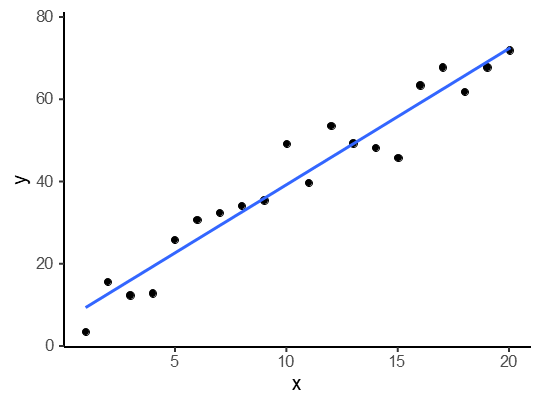

Key is to minimize the "error" - get the line as close to the actual data points as you can.

Running a linear regression in python takes the following syntax:

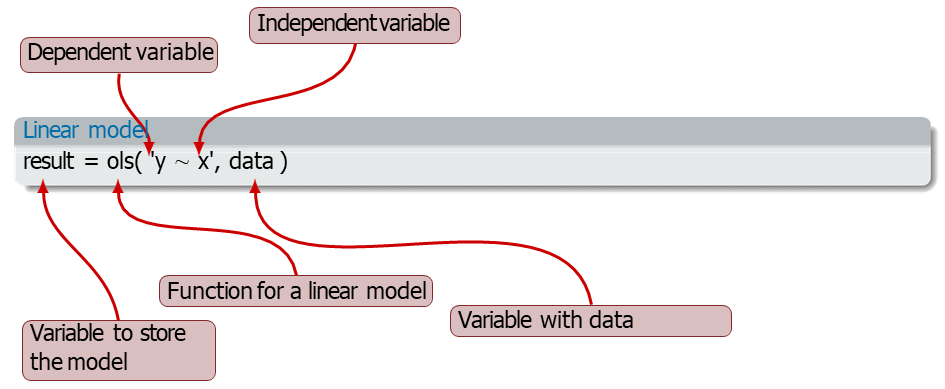

## Building a Model

The econometric models we'll be using are in the `statsmodels` module (specifically the `statsmodels.formula.api` submodule):

In [ ]:
import statsmodels.formula.api as smf 
# notice the smf alias, this will save us from a lot of typing

You can see a list of the different models in this module at the following link: https://www.statsmodels.org/stable/api.html

We'll mostly be using `ols` for an ordinary least squares regression model. Let's build a model looking at the relationship between `mpg` and `disp`:

In [ ]:
results1 = smf.ols("mpg ~ disp", data = df).fit()
print(results1.summary())

What can we say about this model?
* Overall fit? 
    - R-squared
    - Adjusted R-squared
* Estimates/coefficients? 
    - "Intercept"
    - "disp"
* Resulting model? 
    - ***mpg = 49.82 - 0.07\*disp***
* Confidence? 
    - Standard Error
    - t-value
    - *Pr(> |t|)* -- **this is the p-value**
    
To see the scatterplot between `mpg` and `disp` with the regression line added, run this command:

In [ ]:
# Note: we will review how this code works when we cover Visualization

from plotnine import *
(ggplot(df, aes(x = "disp", y = "mpg")) +
    geom_point() + geom_smooth(method = "lm", color = "red"))

What if you want to use more than 1 independent variable in your model...just add them on as follows:
```
yourmodel = smf.ols("y ~ x1 + x2 + x3 + ...", data = df).fit()
```

Now you try it...build a model to explain `mpg` using both `disp` and `weight`. View the results and discuss them with your neighbor.

### Using Categorical Variables

Columns with only a discrete set of values are categorical variables.
* Often these are strings
* But can be numeric coding as well; if so, you'll need to tell Python explicitly that these are not numbers but factors (I'll give examples later.)

Other examples...
* Days of the week, months of the year
* Colors (red, green, blue...)
* States, countries
Python mostly knows how to use these in models by creating indicator or dummy variables.

In the code cell below, copy/paste your previous model and add the `trans` variable:

How would you interpret the estimate for `trans[T.manual]`?

## Using Models to Predict

Although inferential models are typically used to explain the relationships between variables, you may want to get predictions from your model. 

The following command will give us an array of predictions for each observation in our data set. (Think of an "array" as a single row of data.)

In [ ]:
results3.predict()

Getting the predictions in an array isn't very helpful, so instead you can add the predictions to your data:

In [ ]:
df["pred3"] = results3.predict()
df

## Other Common Model Types

### Logistic Regression
**Logistic regression is used when your dependent variable is binary (e.g., yes/no, failure/success, default/no default).**

Although the models from the `statsmodels` package can handle categorical variables with words as independent variables, the dependent variable always needs to be numeric. We are going to build a model to try to predict the type of transmission a car has. However, the `trans` variable is coded with words. 

Before running our logistic regression, we will need to code the categories as 0's and 1's. Let's convert `trans` to 0 (for "automatic") and 1 (for "manual"):

In [ ]:
df["transManual"] = (df["trans"] == "manual").astype(int)
df

*Why do we not need to create another dummy variable for "automatic"?*

Now, let's build a model using `mpg` to predict `trans`...notice that the code is almost exactly the same as for an OLS model, except that we are now using the `logit()` function instead of `ols()`:

In [ ]:
logresults = smf.logit("transManual ~ mpg", data = df).fit()
print(logresults.summary())

Running a logistic regression is very straightforward once you know how to run an OLS regression. However, the mechanics of how a logistic regression is modeled is *very* different because we are now trying to predict the *probability* of the car being either manual or automatic. 

You can see this when you graph the scatter plot as follows:

In [ ]:
df.plot.scatter(x = "mpg", y = "transManual")

Probabilities can't go above 1 or below 0, so we can't just simply draw a straight line through the data.

Instead, a logistic (S-shaped) curve is used to model the probabilities. What this means for us is that the interpretation of the coefficient for `mpg` is no longer straightforward. For example, the coefficient of 0.42 in the model above suggests that, as mpg increases by 1 unit, the *log-odds* of the car being manual increases by 0.42. 

What does that mean...*log-odds*? It's a number most people don't interpret. Instead, we can estimate the average marginal effect using `get_margeff()`:

In [ ]:
print(logresults.get_margeff().summary())

The average marginal effect for `mpg` is 0.0573, which means that, **on average, for each additional mile per gallon a car can travel, the probability of the car being manual increases by 5.73%.**

Now you try... use `mpg`, `disp`, and `weight` to predict `trans` and then get the marginal effects:

### Poisson Regression

**Poisson regression is used when your dependent variable is a counted variable (e.g., # of tickets sold, # of calls received, count of sales transactions).** The key here is that the variable should be non-negative (i.e., >=0) and an integer. The distribution of a counted variable is also often skewed.

Notice that `likes` is a counted variable...here's the histogram once again:

In [ ]:
df["likes"].plot.hist()

Let's use `mpg` to explain `likes` and again notice that the structure of the command only differs with the use of the `poisson()` function:

In [ ]:
poisresults = smf.poisson("likes ~ mpg", data = df).fit()
print(poisresults.get_margeff().summary())

Once again, we need to get the average marginal effects using `get_margeff()` because a poisson regression uses a logistic curve to model the relationship instead of a straight line. But the interpretation of the marginal effect is similar to logistic regression: **for every additional mile per gallon travelled by the car, the number of likes increase, on average, by 29.6 likes**. 

Now you try...use `mpg`, `disp`, and `weight` to explain `likes`:

## In-class Exercise

Your company currently makes generic widgets sold in the country of Sylvania. The neighboring country Freedonia currently has no sales. The Freedonia government has just allowed sales of widgets in their country but will charge
$250,000 for a license to sell in their country next year.

To simplify: (a) Your capacity is unlimited; (b) 4% of gross sales are proﬁt; (c) you have sales for each person in Sylvania for the last year; and (d) you have census data for both countries. The ﬁle is "dataFreedonia.csv"

Should your company enter the Freedonia market?